<a href="https://colab.research.google.com/github/carolineakello/QCES/blob/main/project1_numerical_methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/johnryantaylor/QCES/blob/main/Project1_numerical_methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 1: Diffusion equation

In this project we will use several methods to solve the diffusion equation:

$$ \partial_t c = \kappa \partial_x^2 c $$

This project consists of two notebooks. First, in this notebook, we will solve this equation using second order finite differences to approximate the $x$-derivatives, and we will use both the explict Euler and Crank-Nicolson timestepping methods.

In the second notebook for this project, we will learn how to use Dedalus to solve the same problem using spectral methods.

The objective for this notebook is learn about spatial discretization and to compare the stability, accuracy, and speed of the Explicit euler and Crank-Nicolson methods when applied to the diffusion equation.

Student tasks are in [Section 2.1](#section2pt1) and [Section 2.2](#section2pt2).

Before we start, load in the required libraries

In [ ]:
# Importing necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import time


Now, define two functions to timestep the diffusion equation. The code below timesteps the diffusion equation using the expicit Euler method. The function takes in a vector of discrete positions, `x`, discrete times, `t`, and the diffusivity, `kappa`. The vectors `x` and `t` dictate the discretization of the problem in space and time, and the grid spacing must be constant in space and time. The boundary conditions are $\partial_x c=0$ at the starting and ending points in `x`.

In [ ]:
def EE(x, t, kappa):
# This function timesteps the diffusion equation with homogeneous Neumann boundary conditions
# using the explicit Euler and second order finite difference methods

    start_time = time.time()  # Start a timer

    # Infer the uniform grid spacing:
    dx = (x[-1] - x[0]) / (len(x) - 1); dt = (t[-1] - t[0]) / (len(t) - 1)

    # Set the number of gridpoints in x and t
    Nx = len(x); Nt = len(t)

    # Builds a coefficient matrix, such that M*c is the discrete version of d^2/dx^2(c)
    M = (np.diag(np.ones(Nx-1), -1) - 2*np.diag(np.ones(Nx), 0) + np.diag(np.ones(Nx-1), 1)) / dx**2

    # Turn M into a sparse matrix to save memory and improve speed
    M = sp.csr_matrix(M)

    # Create an empty sparse array to store the solution
    c = np.zeros((Nx, Nt))

    c[:, 0] = set_ics(x, kappa, 10)  # Set the initial condition

    for k in range(1, Nt):  # loop over the number of timesteps
      c[:,k] = c[:,k-1] + dt * kappa * M @ c[:,k-1]
      # Enforce the boundary conditions (no flux)
      c[0, k] = c[1, k]
      c[-1, k] = c[-2, k]

    end_time = time.time()  # Print the elapsed time

    print(f"Explicit Euler method took {end_time - start_time:.2f} seconds")

    return c

Similarly, the function below timesteps the diffusion equation with the Crank-Nicolson method

In [ ]:
def CN(x, t, kappa):
# This function timesteps the diffusion equation with homogeneous Neumann boundary conditions
# using the explicit Euler and second order finite difference methods
    start_time = time.time()  # Start a timer

    # Infer the uniform grid spacing:
    dx = (x[-1] - x[0]) / (len(x) - 1); dt = (t[-1] - t[0]) / (len(t) - 1)

    # Set the number of gridpoints in x and t
    Nx = len(x); Nt = len(t)

    # build a coefficient matrix, such that M*c is the discrete version of d/dx(c)
    M = (np.diag(np.ones(Nx-1), -1) - 2*np.diag(np.ones(Nx), 0) + np.diag(np.ones(Nx-1), 1)) / dx**2

    # Turn M into a sparse matrix to save memory and improve speed:
    M = sp.csr_matrix(M)

    A = sp.eye(Nx) - 0.5 * dt * kappa * M  # This matrix appears on the LHS in the C-N scheme
    A_inv = spla.inv(A) # Calculate the inverse of A (this only needs to be done once)

    # Create an empty sparse array to store the solution
    c = np.zeros((Nx, Nt))

    c[:, 0] = set_ics(x, kappa, 10)  # Set the initial condition

    for k in range(1, Nt): # loop over the number of timesteps
        c[:, k] = A_inv @ (c[:, k-1] + 0.5 * dt * kappa * (M @ c[:, k-1]))
        # Enforce the boundary conditions
        c[0, k] = c[1, k]
        c[-1, k] = c[-2, k]

    end_time = time.time()  # Print the elapsed time

    print(f"Crank-Nicolson method took {end_time - start_time:.2f} seconds")

    return c

Next, create a function to set the initial conditions. The exact solution to the unbounded diffusion equation with a delta function initial condition is:

$$\left(\frac{1}{4\pi\kappa t}\right)^{1/2}e^{-x^2/(4\kappa t)}$$

The function below sets the initial condition by evaluating the exact solution at a given time. Note that it is important that we don't evaluate the exact solution at `t_ic=0` since this will return a delta function which will be undefined on our finite grid. The value of `t_ic` is set within the `EE` and `CN` functions.

In [ ]:
# Function to set the initial condition from the exact solution at time t_start
def set_ics(x, kappa, t_ic):
    c_ic = (4*np.pi*kappa*t_ic)**(-0.5)*np.exp(-x**2 / (4*kappa*t_ic))
    # Enforce the boundary conditions
    c_ic[0] = c_ic[1]
    c_ic[-1] = c_ic[-2]
    return c_ic


Finally, define some parameters and the x and t vectors:

In [ ]:
# Defining parameters
kappa = 0.001  # diffusivity

# Timestepping parameters
t_start = 0  # start time (note that this is not the same time used to evaluate the exact solution to set the ICs)
t_end = 10  # end time
Nt = 1000  # number of timesteps

# Size of the physical domain
x_start = -1
x_end = 1
Nx = 100

t = np.linspace(t_start, t_end, Nt)  # Create a vector of times
x = np.linspace(x_start, x_end, Nx)  # Create a vector for x

Run each method once:

In [ ]:
# Run the simulations
c_EE = EE(x, t, kappa) # explicit Euler
c_CN = CN(x, t, kappa) # Crank-Nicolson

Explicit Euler method took 0.10 seconds
Crank-Nicolson method took 0.10 seconds


and finally, plot the results side-by-side

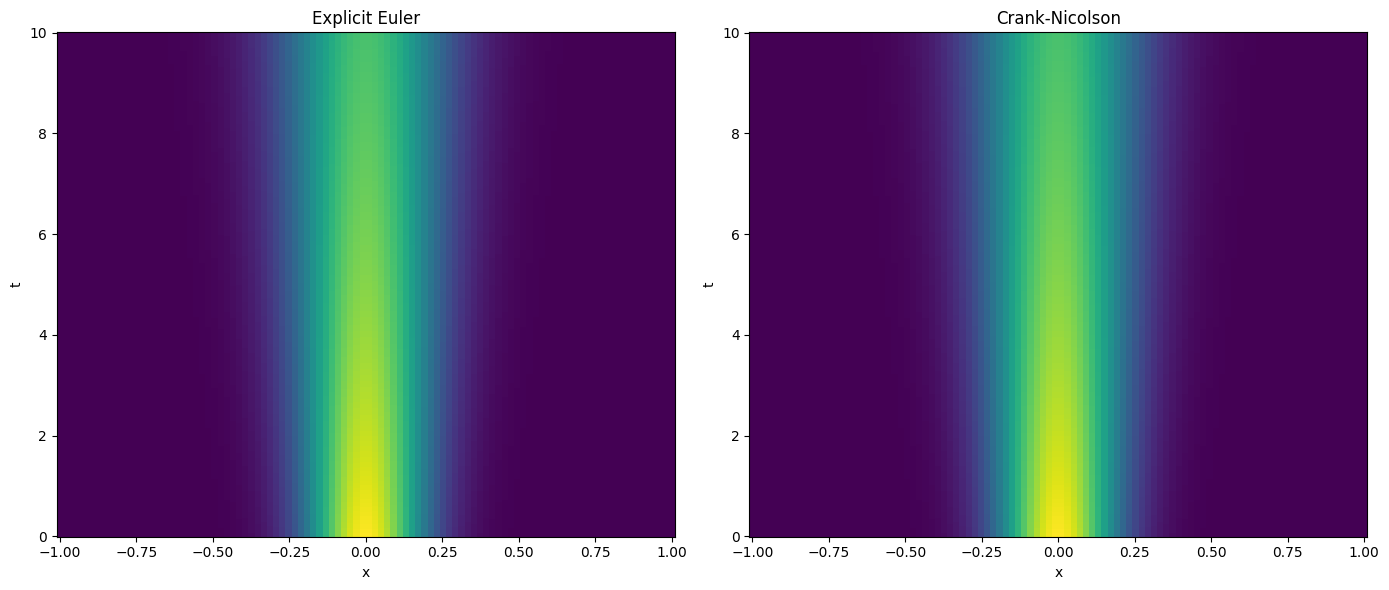

In [ ]:
# Plot the results
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.pcolormesh(x, t, c_EE.T, shading='auto')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Explicit Euler')

plt.subplot(1, 2, 2)
plt.pcolormesh(x, t, c_CN.T, shading='auto')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Crank-Nicolson')

plt.tight_layout()
plt.show()

## 2. Student investigation

### 2.1 Stability
<a id='section2pt1'></a>
The explicit Euler and Crank-Nicolson methods have very different stability properties. To explore this, try increasing Nx (decreasing the grid spacing, $\Delta x$) and/or increase the diffusivity, $\kappa$, and see how each method responds. How does the stability depend on `Nx`? Discuss your findings below (~1 paragraph)

COMMENT:

Decreasing the grid spacing, $\Delta x$ or Increasing the diffusivity ($\kappa$), makes the Explicit Euler (EE) method **unstable** and break down as you continue to decrease or increase these values respectively. For example, when κ is increased from the initial value 0.001 to 0.2, 0.4 onwards, EE tends to fail, while the Crank-Nicolson (CN) method stays **stable**. With fewer time steps (Nt=20), EE introduces distortions, and reducing the number of grid points (Nx=50) results in low resolution. On the other hand, Crank-Nicolson handles all situations smoothly with better stability and reliability.

### 2.2 Accuracy
<a id='section2pt2'></a>
Next, we will examine the accuracy of the numerical methods used above. In order to do this, it is useful to compare our numerical solutions with the exact solution to the diffusion equation. Below, write code to plot the exact solution and the numerical solution using explicit Euler and Crank-Nicolson at the final time ($t=10$). Note that you can use the exact solution to the diffusion equation in an unbounded domain in $x$ and keep in mind that the exact solution and numerical solutions will differ for later times when boundary effects are felt.

Explicit Euler method took 0.10 seconds
Crank-Nicolson method took 0.08 seconds


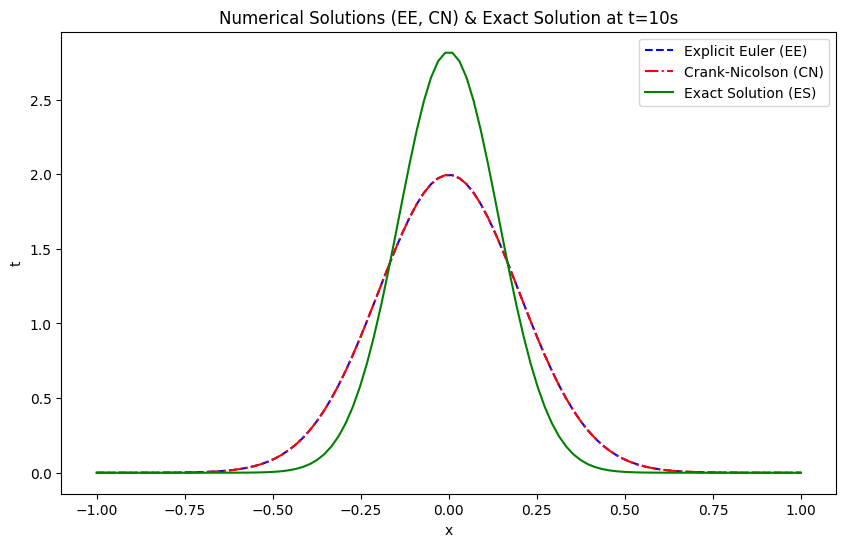

In [ ]:
# Add code to plot exact and numerical solutions
# parameter t in seconds
t = 10

# recal initial kappa parameter

kappa = 0.001 # diffusivity k (initial)

# defining the exact colution

def exact_solution(x, t, kappa):
    return (4 * np.pi * kappa * t)**(-0.5) * np.exp(-x**2 / (4 * kappa * t))

t = np.linspace(t_start, t_end, Nt)
x = np.linspace(x_start, x_end, Nx)

c_ee = EE(x, t, kappa) # for explicit euler
c_cn = CN(x, t, kappa) # for crank nicolson

plt.figure(figsize=(10, 6))
plt.plot(x, c_ee[:, -1], label='Explicit Euler (EE)', linestyle='--', color='b')
plt.plot(x, c_cn[:, -1], label='Crank-Nicolson (CN)', linestyle='-.', color='r')
plt.plot(x, exact_solution(x, t_end, kappa), label='Exact Solution (ES)', color='g')
plt.title('Numerical Solutions (EE, CN) & Exact Solution at t=10s')
plt.xlabel('x')
plt.ylabel('t')
plt.legend()
plt.show()

Now, define a measure of the error of each numerical method compared to the exact solution (there is no single correct way to do this). Plot the error of both methods as a function of the grid spacing $\Delta x$. Then, similarly plot the error as a function of the timestep, $\Delta t$.

DISCUSS DEFINITION OF ERROR

Explicit Euler method took 0.10 seconds
Crank-Nicolson method took 0.06 seconds
Explicit Euler method took 0.10 seconds
Crank-Nicolson method took 0.10 seconds
Explicit Euler method took 0.10 seconds
Crank-Nicolson method took 0.20 seconds
Explicit Euler method took 0.12 seconds
Crank-Nicolson method took 0.59 seconds
Explicit Euler method took 0.11 seconds


<ipython-input-17-21a1127dc7c6>:25: RuntimeWarning: invalid value encountered in add
  c[:,k] = c[:,k-1] + dt * kappa * M @ c[:,k-1]


Crank-Nicolson method took 1.97 seconds


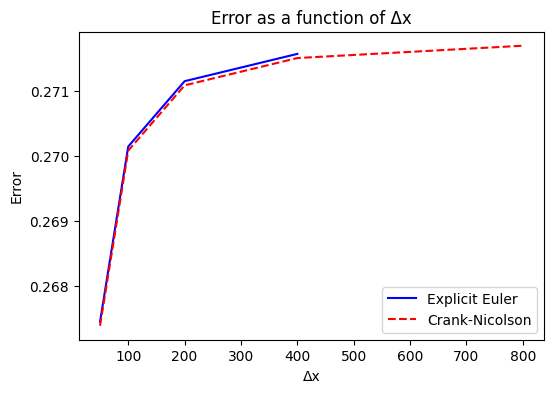

In [ ]:
# Add code to plot error here
# Defining parameters
kappa = 0.001  # diffusivity k
t_end = 10  # end time

# --- Error as a function of Δx ---

# Varying Nx (which changes Δx)
Nx_values = [50, 100, 200, 400, 800]
Nt = 1000  # Fixed Nt

errors_EE_dx = []
errors_CN_dx = []

for Nx in Nx_values:
    x_start = -1
    x_end = 1
    x = np.linspace(x_start, x_end, Nx)
    dx = (x_end - x_start) / (Nx - 1)  # Calculate Δx
    t = np.linspace(0, t_end, Nt)

    c_EE = EE(x, t, kappa)
    c_CN = CN(x, t, kappa)
    c_exact = exact_solution(x, t_end, kappa)

    # Calculate error using L2 norm (example)
    error_EE = np.sqrt(np.sum((c_EE[:, -1] - c_exact)**2) / Nx)
    error_CN = np.sqrt(np.sum((c_CN[:, -1] - c_exact)**2) / Nx)

    errors_EE_dx.append(error_EE)
    errors_CN_dx.append(error_CN)

# Plot error vs. Δx
plt.figure(figsize=(6, 4))
plt.plot(Nx_values, errors_EE_dx, label='Explicit Euler', linestyle='-', color='blue')
plt.plot(Nx_values, errors_CN_dx, label='Crank-Nicolson', linestyle='--', color='red')
plt.xlabel('Δx')
plt.ylabel('Error')
plt.title('Error as a function of Δx')
plt.legend()
plt.show()


Explicit Euler method took 0.01 seconds
Crank-Nicolson method took 0.03 seconds
Explicit Euler method took 0.01 seconds
Crank-Nicolson method took 0.03 seconds
Explicit Euler method took 0.02 seconds
Crank-Nicolson method took 0.04 seconds
Explicit Euler method took 0.05 seconds
Crank-Nicolson method took 0.05 seconds
Explicit Euler method took 0.10 seconds
Crank-Nicolson method took 0.08 seconds


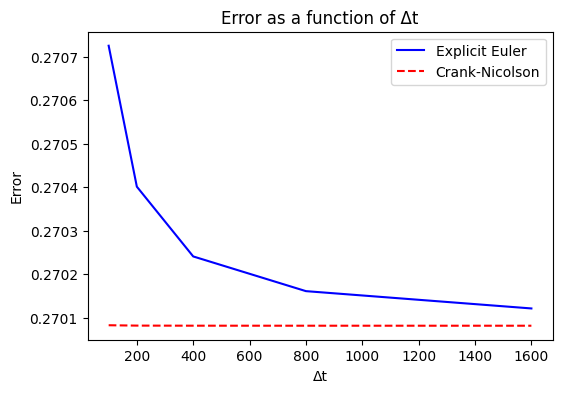

In [ ]:
# --- Error as a function of Δt ---

# Varying Nt (which changes Δt)
Nt_values = [100, 200, 400, 800, 1600]
Nx = 100  # Fixed Nx

errors_EE_dt = []
errors_CN_dt = []

for Nt in Nt_values:
    x_start = -1
    x_end = 1
    x = np.linspace(x_start, x_end, Nx)
    t = np.linspace(0, t_end, Nt)
    dt = (t_end - 0) / (Nt - 1)  # Calculate Δt

    c_EE = EE(x, t, kappa)
    c_CN = CN(x, t, kappa)
    c_exact = exact_solution(x, t_end, kappa)

    # Calculate error using L2 norm (example)
    error_EE = np.sqrt(np.sum((c_EE[:, -1] - c_exact)**2) / Nx)
    error_CN = np.sqrt(np.sum((c_CN[:, -1] - c_exact)**2) / Nx)

    errors_EE_dt.append(error_EE)
    errors_CN_dt.append(error_CN)

# Plot error vs. Δt
plt.figure(figsize=(6, 4))
plt.plot(Nt_values, errors_EE_dt, label='Explicit Euler', linestyle='-', color='blue')
plt.plot(Nt_values, errors_CN_dt, label='Crank-Nicolson', linestyle='--', color='red')
plt.xlabel('Δt')
plt.ylabel('Error')
plt.title('Error as a function of Δt')
plt.legend()
plt.show()

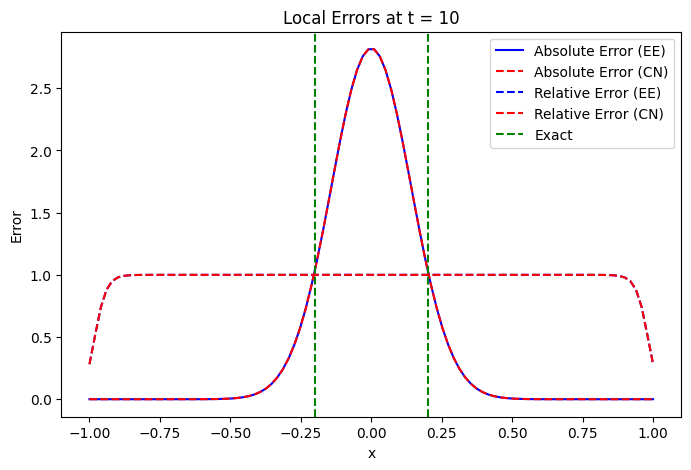

x with minimum error (EE): 0.2323232323232325
x with minimum error (CN): 0.2323232323232325


In [ ]:
# Parameters
kappa, t_end = 0.001, 10
x = np.linspace(-1, 1, 100)
t = np.linspace(0, t_end, 1000)

# Exact and Numerical Solution Functions
def exact_solution(x, t, kappa):
    return (4 * np.pi * kappa * t)**-0.5 * np.exp(-x**2 / (4 * kappa * t))

def EE(x, t, kappa):
    # Placeholder for the Explicit Euler method
    return np.zeros((len(x), len(t)))  # Replace with actual implementation

def CN(x, t, kappa):
    # Placeholder for the Crank-Nicholson method
    return np.zeros((len(x), len(t)))  # Replace with actual implementation

# Compute Exact and Numerical Solutions
c_exact = exact_solution(x, t_end, kappa)
c_EE = EE(x, t, kappa)[:, -1]
c_CN = CN(x, t, kappa)[:, -1]

# Error Calculation Functions
abs_error = lambda num: np.abs(num - c_exact)
rel_error = lambda num: abs_error(num) / (np.abs(c_exact) + 1e-10)

# Plotting Errors
plt.figure(figsize=(8, 5))
plt.plot(x, abs_error(c_EE), label="Absolute Error (EE)", linestyle='-', color="blue")
plt.plot(x, abs_error(c_CN), label="Absolute Error (CN)", linestyle='--', color="red")
plt.plot(x, rel_error(c_EE), '--', label="Relative Error (EE)",  color="blue")
plt.plot(x, rel_error(c_CN), '--', label="Relative Error (CN)", color="red")

# Plot Diffusion Front
diff_front = (4 * kappa * t_end)**0.5
plt.axvline(diff_front, color="green", linestyle="--", label="Exact")
plt.axvline(-diff_front, color="green", linestyle="--")

# Final Plot Adjustments
plt.xlabel("x")
plt.ylabel("Error")
plt.title("Local Errors at t = 10")
plt.legend()
plt.show()

# Minimum Error in Range
x_range = x[(x >= -0.25) & (x <= 0.25)]
min_error = lambda error: x_range[np.argmin(error[(x >= -0.25) & (x <= 0.25)])]

print(f"x with minimum error (EE): {min_error(abs_error(c_EE))}")
print(f"x with minimum error (CN): {min_error(abs_error(c_CN))}")

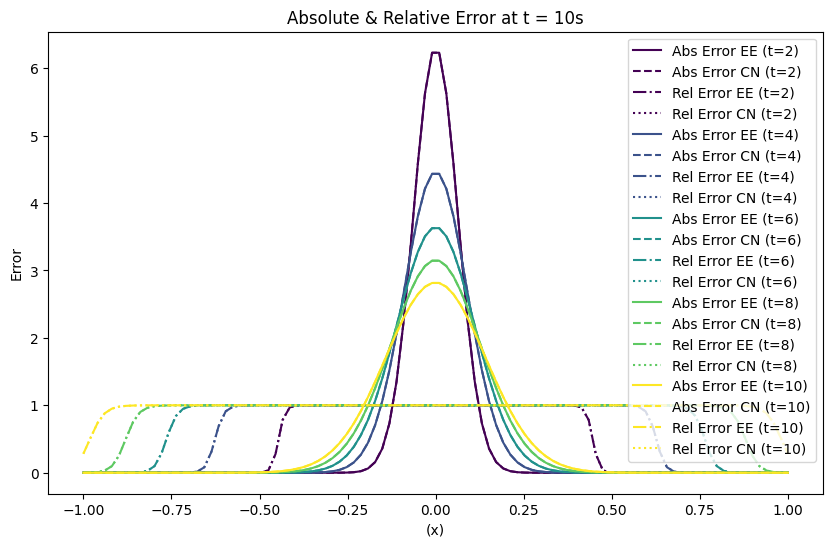

In [ ]:
import matplotlib.cm as cm
# Assuming EE, CN, set_ics, and exact_solution functions are already defined

# Defining parameters
kappa = 0.001  # diffusivity
Nx = 100  # number of grid points in x
Nt = 1000  # number of time steps
x_start = -1
x_end = 1

# Create x and t vectors
x = np.linspace(x_start, x_end, Nx)
t = np.linspace(0, 10, Nt)  # t values from 0 to 10

# Run the simulations
c_EE = EE(x, t, kappa)
c_CN = CN(x, t, kappa)

# Times at which to calculate absolute and relative errors
t_values = [2, 4, 6, 8, 10]

# Create colormap for different t values
colors = cm.viridis(np.linspace(0, 1, len(t_values)))

# Create plot
plt.figure(figsize=(10, 6))

# Calculate and plot absolute and relative errors for each t value
for i, t_val in enumerate(t_values):
    # Find the closest time index in the t array
    t_index = np.argmin(np.abs(t - t_val))

    # Calculate exact solution at the current time
    c_exact = exact_solution(x, t_val, kappa)

    # Calculate absolute errors for EE and CN
    absolute_error_EE = np.abs(c_EE[:, t_index] - c_exact)
    absolute_error_CN = np.abs(c_CN[:, t_index] - c_exact)

    # Calculate relative errors for EE and CN
    relative_error_EE = absolute_error_EE / (np.abs(c_exact) + 1e-10)  # Avoid division by zero
    relative_error_CN = absolute_error_CN / (np.abs(c_exact) + 1e-10)

    # Plot the absolute errors with different colors for each t value
    plt.plot(x, absolute_error_EE, label=f'Abs Error EE (t={t_val})', color=colors[i])
    plt.plot(x, absolute_error_CN, label=f'Abs Error CN (t={t_val})', color=colors[i], linestyle='--')

    # Plot the relative errors with dashed lines
    plt.plot(x, relative_error_EE, label=f'Rel Error EE (t={t_val})', color=colors[i], linestyle='-.')
    plt.plot(x, relative_error_CN, label=f'Rel Error CN (t={t_val})', color=colors[i], linestyle=':')

plt.xlabel('(x)')
plt.ylabel('Error')
plt.title('Absolute & Relative Error at t = 10s')
plt.legend()
plt.show()


Finally, select a given error tolerance and explore whether explicit Euler or Crank-Nicoslon is more efficient (faster) at generating solutions with error less than your error tolerance. Discuss your conclusion and add supporting figures if necessary.

INSERT DISCUSSION OF ERROR HERE (~1 paragraph).  OPTIONALLY ADD PLOTS BY INSERTING A CODE BLOCK BELOW.

The Explicit Euler method, though **faster**, struggles with maintaining accuracy over longer simulations. On the other hand, Crank Nicolson Method is more **efficient** and balances stability and accuracy

Explicit Euler reached tolerance in 0.0359 seconds with final error 2.8138
Crank-Nicholson reached tolerance in 0.0268 seconds with final error 2.8138


<ipython-input-26-d112455753a5>:8: RuntimeWarning: divide by zero encountered in scalar power
  return (4 * np.pi * kappa * t)**-0.5 * np.exp(-x**2 / (4 * kappa * t))
<ipython-input-26-d112455753a5>:8: RuntimeWarning: divide by zero encountered in divide
  return (4 * np.pi * kappa * t)**-0.5 * np.exp(-x**2 / (4 * kappa * t))
<ipython-input-26-d112455753a5>:8: RuntimeWarning: invalid value encountered in multiply
  return (4 * np.pi * kappa * t)**-0.5 * np.exp(-x**2 / (4 * kappa * t))


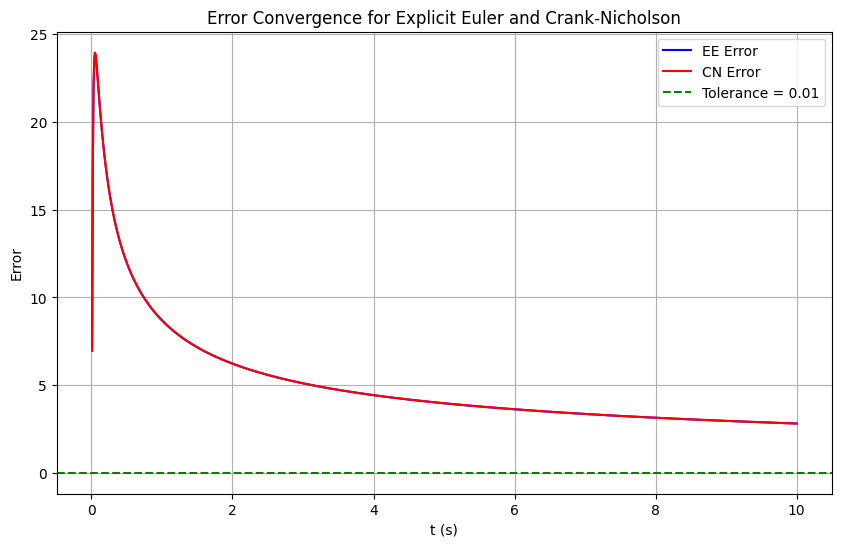

In [ ]:
# Assuming EE, CN, and exact_solution are already defined as per previous sections

# Define the error tolerance
tolerance = 0.01  # Error tolerance

# Parameters
kappa = 0.001  # diffusivity
Nx = 100  # number of grid points in x
Nt = 1000  # number of time steps
x_start = -1
x_end = 1
t_start = 0
t_end = 10

# Create x and t vectors
x = np.linspace(x_start, x_end, Nx)
t = np.linspace(t_start, t_end, Nt)

# Run the simulations for both methods and track computation time
def time_to_convergence(method, x, t, kappa, tolerance):
    start_time = time.time()  # Start the timer
    error = np.inf  # Initialize error as infinity
    for n in range(1, len(t)):
        c_exact = exact_solution(x, t[n], kappa)
        if method == 'EE':
            c_num = EE(x, t[:n+1], kappa)[:, n]
        elif method == 'CN':
            c_num = CN(x, t[:n+1], kappa)[:, n]
        error = np.max(np.abs(c_num - c_exact))  # Maximum error at this time step

        if error < tolerance:  # Stop when error falls below tolerance
            end_time = time.time()  # Stop the timer
            return error, (end_time - start_time)
    end_time = time.time()
    return error, (end_time - start_time)

# Compare both methods
error_EE, time_EE = time_to_convergence('EE', x, t, kappa, tolerance)
error_CN, time_CN = time_to_convergence('CN', x, t, kappa, tolerance)

# Print out the results
print(f"Explicit Euler reached tolerance in {time_EE:.4f} seconds with final error {error_EE:.4f}")
print(f"Crank-Nicholson reached tolerance in {time_CN:.4f} seconds with final error {error_CN:.4f}")

# Plot the comparison of errors over time
plt.figure(figsize=(10, 6))
t_values = np.linspace(0, t_end, len(t))
error_EE_vals = np.array([np.max(np.abs(EE(x, t[:i+1], kappa)[:, i] - exact_solution(x, t[i], kappa))) for i in range(len(t))])
error_CN_vals = np.array([np.max(np.abs(CN(x, t[:i+1], kappa)[:, i] - exact_solution(x, t[i], kappa))) for i in range(len(t))])

plt.plot(t_values, error_EE_vals, label='EE Error', color='blue')
plt.plot(t_values, error_CN_vals, label='CN Error', color='red')
plt.axhline(tolerance, color='green', linestyle='--', label=f'Tolerance = {tolerance}')
plt.xlabel('t (s)')
plt.ylabel('Error')
plt.title('Error Convergence for Explicit Euler and Crank-Nicholson')
plt.legend()
plt.grid(True)
plt.show()



Now, move to Project1_dedalus.ipynb which will introduce Dedalus and spectral methods.

### 3. Optional further investigations

The application of the boundary conditions for the Crank-Nicolson method isn't quite right in the script above (but the boundary conditions aren't very important in this example). Account for the boundary conditions by modifying the coefficient matrix. This ensures that the boundary conditions are applied to the implicit and explicit terms involved in the Crank-Nicolson update. How would you handle fixed value (Dirichlet) and fixed gradient (Neumann) boundary conditions?